<a href="https://colab.research.google.com/github/llayer/ml_exercise/blob/master/Higgs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Higgs ML dataset studies

In [0]:
import pandas as pd
import numpy as np

In [2]:
!git clone https://github.com/llayer/ml_exercise

fatal: destination path 'ml_exercise' already exists and is not an empty directory.


In [3]:
!pip3 install scikit-optimize

In [2]:
! ls

ml_exercise  sample_data  xgboost.h5


## 1. Load data

In [0]:
sig = pd.read_hdf('ml_exercise/higgs_signal.h5')
bkg = pd.read_hdf('ml_exercise/higgs_bkg.h5')

In [4]:
sig.head()

,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1_pt,jet1_eta,jet1_phi,jet1_btag,jet2_pt,jet2_eta,jet2_phi,jet2_btag,jet3_pt,jet3_eta,jet3_phi,jet3_btag,jet4_pt,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,label
0,0.723801,-0.914611,0.910944,1.194830,-0.448292,0.839489,-0.871428,0.587799,0.000000,0.654446,1.159881,-0.725923,0.000000,0.422018,1.636800,-0.880565,0.000000,1.033994,-0.704196,-0.916982,3.101961,0.867059,1.127180,1.211664,0.695883,0.694068,0.755813,0.761658,0
1,1.974119,0.660297,-1.362428,1.234102,1.677716,1.478815,0.408940,-0.105273,0.000000,1.017048,-0.127190,0.363313,2.214872,0.918675,0.072083,1.162631,0.000000,0.961458,0.629154,1.604089,3.101961,1.938668,1.233898,0.990063,0.524871,0.900614,0.917613,1.083369,0
2,0.946889,0.169416,1.210014,0.343294,-1.579545,0.999435,1.030804,-0.475041,0.000000,0.435374,0.054457,-0.083982,0.000000,1.465033,0.613681,1.492698,2.548224,1.192695,0.190256,0.558635,3.101961,0.881641,0.845381,0.997408,0.695120,0.787132,0.657668,0.721147,0
3,1.298084,-0.897079,1.224441,0.618091,0.856746,0.493122,-0.021810,-1.520042,2.173076,0.973234,0.325470,-0.250431,2.214872,0.782569,-0.841807,-0.817325,0.000000,0.810789,-1.033162,0.581386,0.000000,0.848238,0.925814,0.973957,0.961469,0.946147,1.028120,0.848133,0
4,1.022289,-0.481195,0.169649,1.103255,0.744424,1.648197,-0.780327,-1.484007,2.173076,0.675472,0.507117,0.395493,0.000000,0.540036,0.139441,-0.549385,0.000000,0.802513,-1.164748,-0.284934,1.550981,0.717778,0.752909,0.996800,1.648921,1.138676,1.118826,0.977200,0


In [0]:
data = pd.concat([sig, bkg])

### Split data in train and validation set

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

def prep_data(data, val_size = 0.2):

    features = data.drop(['label'], axis=1)
    labels = data[['label']].values.ravel()
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=val_size, random_state=42)

    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = prep_data(data)

## 2. Feature importance with XGBoost

In [0]:
import xgboost as xgb
from xgboost import plot_importance

def get_feature_importance(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.33, random_state=42)

    # Early stopping
    early_stopping_rounds = 5

    # Define model
    model_bdt = xgb.XGBClassifier(n_jobs = 4)

    # Last in list is used for early stopping
    eval_set = [(X_train, y_train), (X_test, y_test)]

    # Fit with early stopping
    model_bdt.fit(X_train, y_train, eval_metric=["logloss"], eval_set=eval_set, 
                early_stopping_rounds=early_stopping_rounds, verbose=False)
    
    plot_importance(model_bdt)
    fscore = list(model_bdt.feature_importances_)
    feature_importance = pd.DataFrame(list(data.drop(['label'], axis=1)))
    feature_importance['f-score'] = fscore
    feature_importance.columns = ['feature', 'fscore']
    feature_importance = feature_importance.sort_values(by=['fscore'], ascending=False)

    return feature_importance


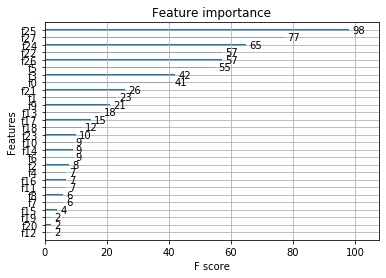

In [8]:
feature_importance = get_feature_importance(X_train, y_train)

In [9]:
feature_importance.head()

,feature,fscore
25,m_bb,0.139647
26,m_wbb,0.090148
27,m_wwbb,0.078791
22,m_jjj,0.075887
5,jet1_pt,0.072598


## Test algorithms

### Set up Bayesian optimization

In [0]:
import xgboost as xgb
import skopt
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression

def fit_lreg(X_train, y_train, X_test, y_test, p):

    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    predictions = model_bdt.clf(X_test)[:,1]
    return roc_auc_score(y_test, predictions)


def fit_xgboost(X_train, y_train, X_test, y_test, p):

    # Early stopping
    early_stopping_rounds = 10
    # Define model
    model_bdt = xgb.XGBClassifier(n_jobs = 4, n_estimators = p['n_estimators'], learning_rate = p['learning_rate'],
                            max_depth = p['max_depth'], min_child_weight = p['min_child_weight'])
    # Last in list is used for early stopping
    eval_set = [(X_train, y_train), (X_test, y_test)]
    # Fit with early stopping
    #model_bdt.fit(X_train, y_train, eval_metric=["logloss"], eval_set=eval_set, 
    #                early_stopping_rounds=early_stopping_rounds, verbose=False)
    model_bdt.fit(X_train, y_train, eval_metric=["logloss"])
    predictions = model_bdt.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, predictions)

def fit_keras(X_train, y_train, X_test, y_test, p):

    # Early stopping
    patience = 5
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience)
    
    # Define model
    model = create_model(X_train.shape[1], p['dense_layers'], p['dense_units'], 0., 
                            #p['regulizer_value'], 
                            p['dropout_value'], 
                            p['learning_rate'])
    
    #history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 100,# p['batch_size'], 
    #                    epochs=1000, verbose=0, callbacks=[es])

    history = model.fit(X_train, y_train, batch_size = p['batch_size'], epochs=p['epochs'], verbose=0)

    predictions = model.predict(X_test)
    return roc_auc_score(y_test, predictions)


def optimize( algo, dimensions, initial_param, data, cv = False, kfold_splits = 5, num_calls=12, random_state = 42): 

    prior_values = []
    prior_names = []
    for var in dimensions:
        name = var.name
        print( name )
        prior_names.append(name)
        prior_values.append(initial_param[name])

    global num_skopt_call
    num_skopt_call = 0
    #errors = []

    @use_named_args(dimensions)
    def fitness(**p): 

        global num_skopt_call

        print('\n \t ::: {} SKOPT CALL ::: \n'.format(num_skopt_call+1))
        print(p)

        reduced_feat = feature_importance.iloc[0:p['n_feat']]
        reduced_feat = list(reduced_feat['feature'])
        data_red = data[reduced_feat]
        features = data_red.values
        labels = data[['label']].values.ravel()

        if cv == False:
            X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=random_state)
            if algo == 'xgboost':
                score = fit_xgboost(X_train, y_train, X_test, y_test, p)
            if algo == 'keras':
                score = fit_keras(X_train, y_train, X_test, y_test, p)
            print(score)

        else:
            cv_scores = []    
            enum = enumerate(KFold(n_splits=kfold_splits, shuffle=True, random_state=random_state).split(features,labels))
            for i,(index_train, index_valid) in enum:
                X_train, X_test = features[ index_train ], features[ index_valid ]
                y_train, y_test = labels[ index_train ], labels[ index_valid ]   
                if algo == 'xgboost':
                    score = fit_xgboost(X_train, y_train, X_test, y_test, p)
                if algo == 'keras':
                    score = fit_keras(X_train, y_train, X_test, y_test, p)
                print(score)
                cv_scores.append(score)
                #print( cv_scores )
            score = np.mean(cv_scores)
            print(score)
            print(np.std(cv_scores))

        num_skopt_call += 1

        return -1*score

    search_result = gp_minimize( func = fitness, dimensions = dimensions,
                                 acq_func = 'EI', # Expected Improvement
                                 n_calls = num_calls, x0 = prior_values )

    params = pd.DataFrame(search_result['x_iters'])
    params.columns = [*prior_names]
    params = params.rename_axis('call').reset_index()
    scores = pd.DataFrame(search_result['func_vals'])
    scores.columns = ['score']
    result = pd.concat([params, scores], axis=1)
    result = result.sort_values(by=['score'])
    #errors_frame = pd.DataFrame(errors, columns = ['call', 'q_error', 't_error'])
    #result = pd.merge(result, errors_frame, on=['call'])   
    
    return result

### 1. XGBoost

In [0]:
from skopt.space import Real, Categorical, Integer

# Skopt dimensions
skopt_dims = [       
    Integer(        low=20,    high=200,                         name='n_estimators'     ),
    Real(        low=1e-2, high=1,     prior='log-uniform', name='learning_rate'     ),
    Integer(        low=2,    high=20,                         name='max_depth'     ),
    Integer(        low=1,    high=30,                         name='min_child_weight'     ),
    Real(        low=1e-6, high=1e-2,     prior='log-uniform', name='reg_alpha'     ),
    Integer(     low=5,    high=27,                        name='n_feat'       )

]

# Initial parameters
init_param = {'n_estimators' : 100, 'learning_rate' : 0.3, 'reg_alpha' : 1e-5, 'max_depth' : 6, 'min_child_weight' : 1, 'n_feat':12 }

In [17]:
search_result = optimize('xgboost', skopt_dims, init_param, data, cv = True, num_calls=50, random_state = 42)

n_estimators
learning_rate
max_depth
min_child_weight
reg_alpha
n_feat

 	 ::: 1 SKOPT CALL ::: 

{'n_estimators': 100, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1e-05, 'n_feat': 12}
0.7811189147168113
0.0068822956674509765

 	 ::: 2 SKOPT CALL ::: 

{'n_estimators': 104, 'learning_rate': 0.6179507087969082, 'max_depth': 13, 'min_child_weight': 7, 'reg_alpha': 0.006289449243522464, 'n_feat': 22}
0.7566188989617335
0.005664474648282307

 	 ::: 3 SKOPT CALL ::: 

{'n_estimators': 41, 'learning_rate': 0.03541470984030101, 'max_depth': 17, 'min_child_weight': 3, 'reg_alpha': 1.1639759205860849e-05, 'n_feat': 11}
0.7756162446752677
0.0078047518754549685

 	 ::: 4 SKOPT CALL ::: 

{'n_estimators': 42, 'learning_rate': 0.2219420434019009, 'max_depth': 4, 'min_child_weight': 12, 'reg_alpha': 3.751905220326583e-05, 'n_feat': 14}
0.7921974548940319
0.00820642051053117

 	 ::: 5 SKOPT CALL ::: 

{'n_estimators': 126, 'learning_rate': 0.3231581330284767, 'max_depth'

In [0]:
search_result.to_hdf('xgboost.h5', 'frame')

### 2. Keras

In [0]:
import keras
from keras.layers import Input, Flatten, Dense, Dropout, Reshape

def create_model( n_features, dense_layers, dense_units, regulizer_value, dropout_value, learning_rate ):

    m_input = Input(shape = (n_features, ))
    m = m_input
    
    for _ in range(dense_layers):
        m = Dense( units=dense_units, activation='relu', 
                   kernel_initializer='lecun_normal',
                   kernel_regularizer=keras.regularizers.l2(regulizer_value) )(m)
        m = Dropout(dropout_value)(m)

    m_output = Dense( units=1, activation='sigmoid', 
                      kernel_initializer='lecun_normal',
                      kernel_regularizer=keras.regularizers.l2(regulizer_value) )(m)

    model = keras.models.Model(inputs=m_input, outputs=m_output)
    model.compile( loss = 'binary_crossentropy',
                        optimizer = keras.optimizers.Adam(lr=learning_rate) )
    return model

In [0]:
dimensions = [
    Integer(        low=20,    high=200,                         name='epochs'     ),
    Integer(     low=1,    high=5,                        name='dense_layers'      ),
    Integer(     low=100,    high=1000,                    name='batch_size'      ),
    Integer(     low=5,    high=200,                        name='dense_units'       ),
    #Real(        low=1e-3, high=0.9,  prior="log-uniform", name='regulizer_value'   ),
    Real(        low=1e-3, high=0.5,   prior="log-uniform",                    name='dropout_value'     ),
    Real(        low=1e-4, high=1e-1, prior='log-uniform', name='learning_rate'     ),
    Integer(     low=5,    high=27,                        name='n_feat'       )

]


# Initial parameters
init_param = {'epochs' : 50 ,'learning_rate' : 1e-2, 'dense_layers' : 3, 'regulizer_value' : 1e-2, 'dropout_value': 0.02, 
             'dense_units' : 20, 'batch_size' : 100, 'n_feat': 20}

In [0]:
search_result_k = optimize('keras', dimensions, init_param, data, cv = True, num_calls=50, random_state = 42)

epochs
dense_layers
batch_size
dense_units
dropout_value
learning_rate
n_feat

 	 ::: 1 SKOPT CALL ::: 

{'epochs': 50, 'dense_layers': 3, 'batch_size': 100, 'dense_units': 20, 'dropout_value': 0.02, 'learning_rate': 0.01, 'n_feat': 20}
0.7478641197368062
0.746250016562703
0.7525858743294203
0.7572125213346588
0.7573090375741859
0.7522443139075549
0.004594972818457291

 	 ::: 2 SKOPT CALL ::: 

{'epochs': 144, 'dense_layers': 4, 'batch_size': 665, 'dense_units': 148, 'dropout_value': 0.05453826273784942, 'learning_rate': 0.0008095500745638747, 'n_feat': 10}
0.7633003878600044
0.7787447896236729
0.7698653727731828
0.7806238160436634
0.7849946874287155
0.7755058107458479
0.007842329136779274

 	 ::: 3 SKOPT CALL ::: 

{'epochs': 187, 'dense_layers': 2, 'batch_size': 217, 'dense_units': 181, 'dropout_value': 0.058603859161523206, 'learning_rate': 0.0004935612577472992, 'n_feat': 13}
0.764309228907909
0.7864018834230719
0.7676592133781667
0.7771700083150463
0.7812861424929666
0.77536529530